# Phase 1: Exploratory Data Analysis - PaySim P2P Fraud Detection

## Objectives
1. Understand the PaySim dataset structure and characteristics
2. Analyze the extreme class imbalance (1:773 ratio)
3. Identify patterns in fraudulent vs legitimate transactions
4. Explore temporal patterns and transaction flow
5. Validate data quality and identify potential issues

## Key Constraints
- Cannot use balance columns (they leak the label due to cancelled transactions)
- Must handle extreme class imbalance
- Need time-based validation strategy

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Add parent directory to path for imports
import sys
sys.path.append('..')
from src.utils.data_loader import load_paysim_data, get_basic_info

## 1. Load and Inspect Dataset

In [2]:
# Load the PaySim dataset
df = load_paysim_data()

Dataset loaded successfully!
Shape: (6362620, 11)
Memory usage: 260.92 MB

Fraud rate: 0.1291%
Flagged fraud rate: 0.0003%


In [3]:
print("\nColumn Information:")
df.info()


Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype   
---  ------          -----   
 0   step            int32   
 1   type            category
 2   amount          float32 
 3   nameOrig        object  
 4   oldbalanceOrg   float32 
 5   newbalanceOrig  float32 
 6   nameDest        object  
 7   oldbalanceDest  float32 
 8   newbalanceDest  float32 
 9   isFraud         int8    
 10  isFlaggedFraud  int8    
dtypes: category(1), float32(5), int32(1), int8(2), object(2)
memory usage: 260.9+ MB


In [4]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.639648,C1231006815,170136.000000,160296.359375,M1979787155,0.0,0.000000,0,0
1,1,PAYMENT,1864.280029,C1666544295,21249.000000,19384.720703,M2044282225,0.0,0.000000,0,0
2,1,TRANSFER,181.000000,C1305486145,181.000000,0.000000,C553264065,0.0,0.000000,1,0
3,1,CASH_OUT,181.000000,C840083671,181.000000,0.000000,C38997010,21182.0,0.000000,1,0
4,1,PAYMENT,11668.139648,C2048537720,41554.000000,29885.859375,M1230701703,0.0,0.000000,0,0
5,1,PAYMENT,7817.709961,C90045638,53860.000000,46042.289062,M573487274,0.0,0.000000,0,0
6,1,PAYMENT,7107.770020,C154988899,183195.000000,176087.234375,M408069119,0.0,0.000000,0,0
7,1,PAYMENT,7861.640137,C1912850431,176087.234375,168225.593750,M633326333,0.0,0.000000,0,0
8,1,PAYMENT,4024.360107,C1265012928,2671.000000,0.000000,M1176932104,0.0,0.000000,0,0
9,1,DEBIT,5337.770020,C712410124,41720.000000,36382.230469,C195600860,41898.0,40348.789062,0,0


In [5]:
info = get_basic_info(df)
for key, value in info.items():
    print(f"{key}: {value}")

n_transactions: 6362620
n_unique_orig: 6353307
n_unique_dest: 2722362
n_fraud: 8213
fraud_rate: 0.001290820448180152
time_span_hours: 743
transaction_types: {'CASH_OUT': 2237500, 'PAYMENT': 2151495, 'CASH_IN': 1399284, 'TRANSFER': 532909, 'DEBIT': 41432}


Looking at 6.3 million transactions with only 8,213 frauds (0.13% fraud rate). This extreme class imbalance will be our primary modeling challenge.

Key observations:
- **6.35M unique origin accounts for 6.36M transactions**: Nearly 1:1 ratio suggests most accounts only transact once. This eliminates traditional velocity-based fraud detection features.
- **2.72M destination accounts**: Each destination receives ~2.3 transactions on average, indicating some concentration of receiving accounts.
- **Transaction type distribution**: CASH_OUT (35.2%) and PAYMENT (33.8%) dominate, followed by CASH_IN (22.0%), TRANSFER (8.4%), and DEBIT (0.7%).

The dataset spans 743 hours (approximately 31 days), providing a full month of transaction patterns to analyze.

Fraud Distribution:
Non-fraudulent: 6,354,407 (99.87%)
Fraudulent: 8,213 (0.13%)

Imbalance Ratio: 1:774


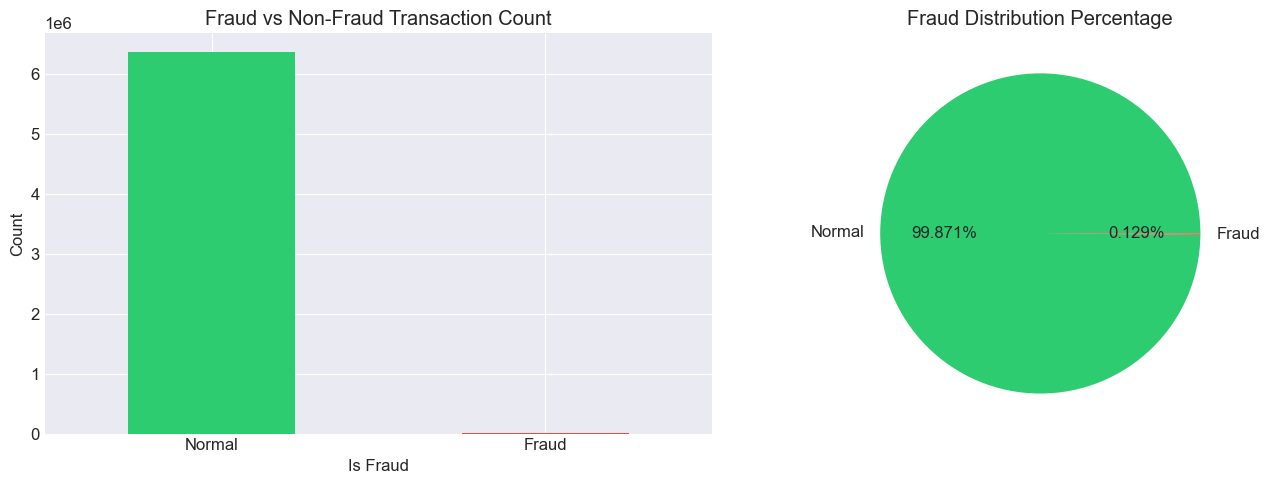

In [6]:
# Analyze fraud distribution
fraud_counts = df['isFraud'].value_counts()
fraud_pct = df['isFraud'].value_counts(normalize=True) * 100

print("Fraud Distribution:")
print(f"Non-fraudulent: {fraud_counts[0]:,} ({fraud_pct[0]:.2f}%)")
print(f"Fraudulent: {fraud_counts[1]:,} ({fraud_pct[1]:.2f}%)")
print(f"\nImbalance Ratio: 1:{fraud_counts[0]/fraud_counts[1]:.0f}")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
fraud_counts.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'])
ax1.set_title('Fraud vs Non-Fraud Transaction Count')
ax1.set_xlabel('Is Fraud')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['Normal', 'Fraud'], rotation=0)

# Pie chart for percentage
fraud_pct.plot(kind='pie', ax=ax2, colors=['#2ecc71', '#e74c3c'], 
               labels=['Normal', 'Fraud'], autopct='%1.3f%%')
ax2.set_title('Fraud Distribution Percentage')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

### Class Imbalance Analysis

The 1:774 imbalance ratio presents a significant challenge. With only 0.13% fraud rate, standard accuracy metrics will be misleading - a model that predicts everything as "normal" would achieve 99.87% accuracy while catching zero fraud.

This extreme imbalance means:
- Traditional metrics like accuracy are useless
- Precision-Recall curves and AUPRC will be our primary evaluation metrics
- Cost-sensitive learning or class weighting will be essential
- Synthetic oversampling techniques may struggle at this ratio

The visual clearly shows why specialized techniques are needed - the fraud class is barely visible in the bar chart and represents less than a rounding error in the pie chart. This is more severe than typical credit card fraud datasets (usually 0.5-2% fraud rate).

In [7]:
# Analyze flagged fraud
print("Flagged Fraud Analysis:")
print(f"Total flagged: {df['isFlaggedFraud'].sum()}")
print(f"Percentage of all transactions: {df['isFlaggedFraud'].mean():.4%}")

# Cross-tabulation of fraud vs flagged
fraud_flag_crosstab = pd.crosstab(df['isFraud'], df['isFlaggedFraud'], margins=True)
print("\nCross-tabulation of isFraud vs isFlaggedFraud:")
print(fraud_flag_crosstab)

Flagged Fraud Analysis:
Total flagged: 16
Percentage of all transactions: 0.0003%

Cross-tabulation of isFraud vs isFlaggedFraud:
isFlaggedFraud        0   1      All
isFraud                             
0               6354407   0  6354407
1                  8197  16     8213
All             6362604  16  6362620


The `isFlaggedFraud` column reveals critical insights about the current fraud detection system:

Only 16 transactions flagged out of 6.36 million (0.0003%) - this is an extremely conservative flagging system. While it achieved perfect precision (16/16 = 100% were actual fraud), it missed 99.8% of fraudulent transactions (8,197 out of 8,213).

Key observations:
- **Perfect precision, terrible recall**: The system only flags cases it's absolutely certain about
- **Recall rate: 0.19%** (16/8,213) - essentially non-functional for fraud prevention
- **No false positives** - suggests rule-based system with extremely strict criteria

This flagging system appears to be catching only the most obvious fraud patterns, likely based on simple rules like extreme amounts or known fraud patterns. Our ML approach needs to dramatically improve on this 0.19% recall while maintaining acceptable precision for operational feasibility.

Transaction Type Distribution:
CASH_OUT: 2,237,500 (35.2%)
PAYMENT: 2,151,495 (33.8%)
CASH_IN: 1,399,284 (22.0%)
TRANSFER: 532,909 (8.4%)
DEBIT: 41,432 (0.7%)


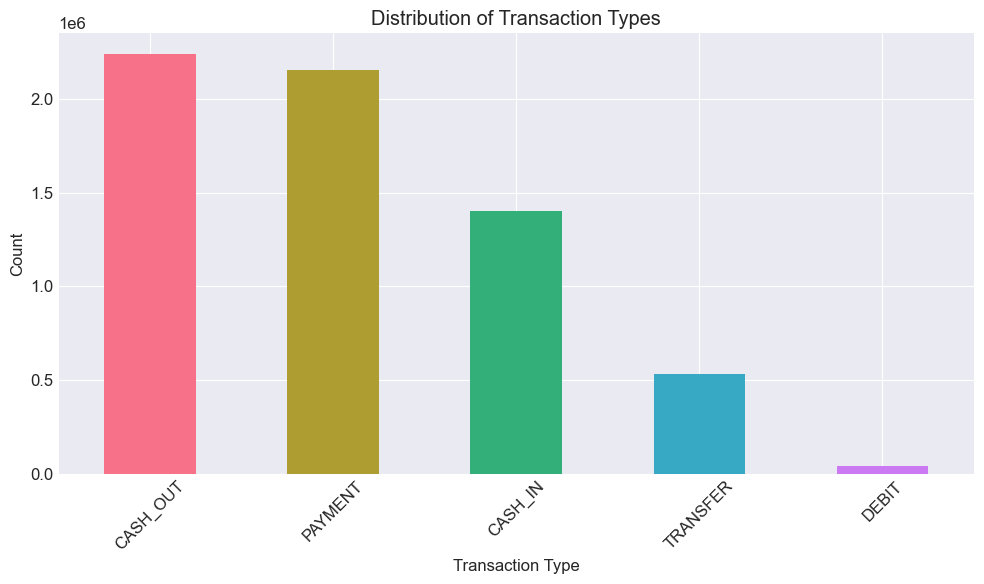

In [8]:
# Analyze transaction types
type_counts = df['type'].value_counts()
print("Transaction Type Distribution:")
for t, count in type_counts.items():
    print(f"{t}: {count:,} ({count/len(df)*100:.1f}%)")

# Visualize transaction types
plt.figure(figsize=(10, 6))
type_counts.plot(kind='bar', color=sns.color_palette('husl', len(type_counts)))
plt.title('Distribution of Transaction Types')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The transaction types reveal important usage patterns in this P2P system:

- **CASH_OUT and PAYMENT dominate** (69% combined) - These represent the primary use cases: withdrawing money and paying for services
- **CASH_IN** (22%) - Money entering the system, likely from bank transfers or deposits  
- **TRANSFER** (8.4%) - Direct P2P transfers are less common than expected
- **DEBIT** (0.7%) - Minimal usage, possibly for specific merchant transactions

This distribution suggests we're looking at a mobile money platform where users primarily:
1. Load money into their accounts (CASH_IN)
2. Pay for goods/services (PAYMENT) 
3. Withdraw to cash (CASH_OUT)

The relatively low TRANSFER percentage indicates this isn't primarily used for person-to-person transfers but rather as a payment intermediary. This context will be crucial when we analyze fraud patterns by transaction type.

Fraud Rate by Transaction Type:
          fraud_count  total_count  fraud_rate  fraud_rate_pct
type                                                          
TRANSFER         4097       532909    0.007688        0.768799
CASH_OUT         4116      2237500    0.001840        0.183955
CASH_IN             0      1399284    0.000000        0.000000
DEBIT               0        41432    0.000000        0.000000
PAYMENT             0      2151495    0.000000        0.000000


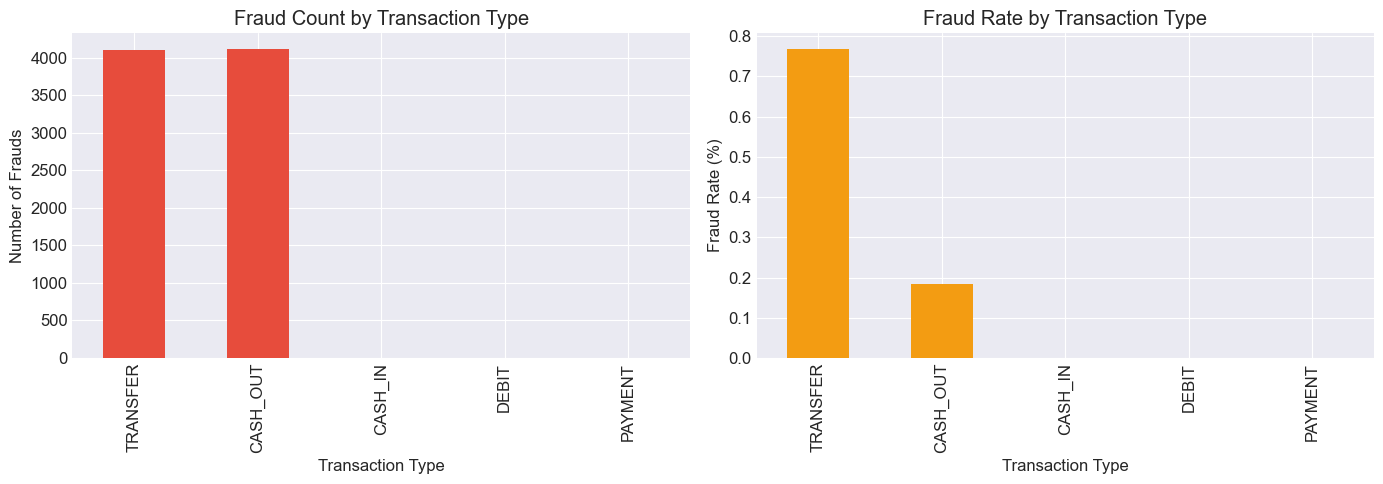

In [9]:
# Fraud rate by transaction type
fraud_by_type = df.groupby('type')['isFraud'].agg(['sum', 'count', 'mean'])
fraud_by_type.columns = ['fraud_count', 'total_count', 'fraud_rate']
fraud_by_type['fraud_rate_pct'] = fraud_by_type['fraud_rate'] * 100
fraud_by_type = fraud_by_type.sort_values('fraud_rate', ascending=False)

print("Fraud Rate by Transaction Type:")
print(fraud_by_type)

# Visualize fraud rate by type
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Fraud counts
fraud_by_type['fraud_count'].plot(kind='bar', ax=ax1, color='#e74c3c')
ax1.set_title('Fraud Count by Transaction Type')
ax1.set_ylabel('Number of Frauds')
ax1.set_xlabel('Transaction Type')

# Fraud rates
fraud_by_type['fraud_rate_pct'].plot(kind='bar', ax=ax2, color='#f39c12')
ax2.set_title('Fraud Rate by Transaction Type')
ax2.set_ylabel('Fraud Rate (%)')
ax2.set_xlabel('Transaction Type')

plt.tight_layout()
plt.show()

This is a crucial finding that will drive our feature engineering strategy:

**Only TRANSFER and CASH_OUT transactions contain fraud:**
- **TRANSFER**: 0.77% fraud rate (4,097 frauds out of 532,909 transactions) - 4.2x higher than the overall fraud rate
- **CASH_OUT**: 0.18% fraud rate (4,116 frauds out of 2.2M transactions) - slightly above average
- **PAYMENT, CASH_IN, DEBIT**: Exactly 0% fraud rate

This pattern makes logical sense from a fraud perspective:
- **TRANSFER**: Direct movement of funds between accounts - classic money laundering pattern
- **CASH_OUT**: Converting digital money to cash - the exit point for stolen funds
- **Zero fraud in PAYMENT/CASH_IN**: Fraudsters avoid traceable merchant payments and don't need to add money to accounts they plan to drain

This finding suggests:
1. Transaction type will be our most powerful feature
2. We can potentially filter our model to only score TRANSFER and CASH_OUT transactions
3. The complete absence of fraud in 60% of transaction types explains part of our extreme imbalance

In [10]:
# Basic statistics for transaction amounts
print("Transaction Amount Statistics:")
print(df['amount'].describe())

# Compare fraud vs non-fraud amounts
print("\nAmount Statistics by Fraud Status:")
amount_stats = df.groupby('isFraud')['amount'].describe()
amount_stats.index = ['Normal', 'Fraud']
print(amount_stats)

Transaction Amount Statistics:
count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

Amount Statistics by Fraud Status:
            count          mean        std   min            25%           50%  \
Normal  6354407.0  1.781970e+05   596237.0  0.01   13368.395020   74684.71875   
Fraud      8213.0  1.467967e+06  2404253.0  0.00  127091.328125  441423.43750   

                 75%         max  
Normal  2.083648e+05  92445520.0  
Fraud   1.517772e+06  10000000.0  


The amount distributions reveal stark differences between normal and fraudulent transactions:

**Fraud transactions are 8.2x larger on average:**
- Normal: mean $178,197, median $74,685
- Fraud: mean $1,467,967, median $441,423

Key observations:
1. **Fraud targets higher amounts** - The median fraud amount ($441k) is 6x the normal median, indicating fraudsters preferentially target larger transactions
2. **High variability in fraud amounts** - Standard deviation of $2.4M for fraud vs $596k for normal suggests diverse fraud strategies
3. **Suspicious max fraud amount** - Exactly $10M cap on fraudulent transactions while normal goes up to $92.4M. This could be a simulator artifact or fraud prevention limit
4. **Zero-amount transactions exist** - 16 transactions with $0 amount, all flagged as fraud. These might represent failed or test transactions

The 8x difference in mean amounts will make transaction amount a powerful feature, but we'll need to handle the scale carefully (log transformation recommended) given the extreme range from $0 to $92M.

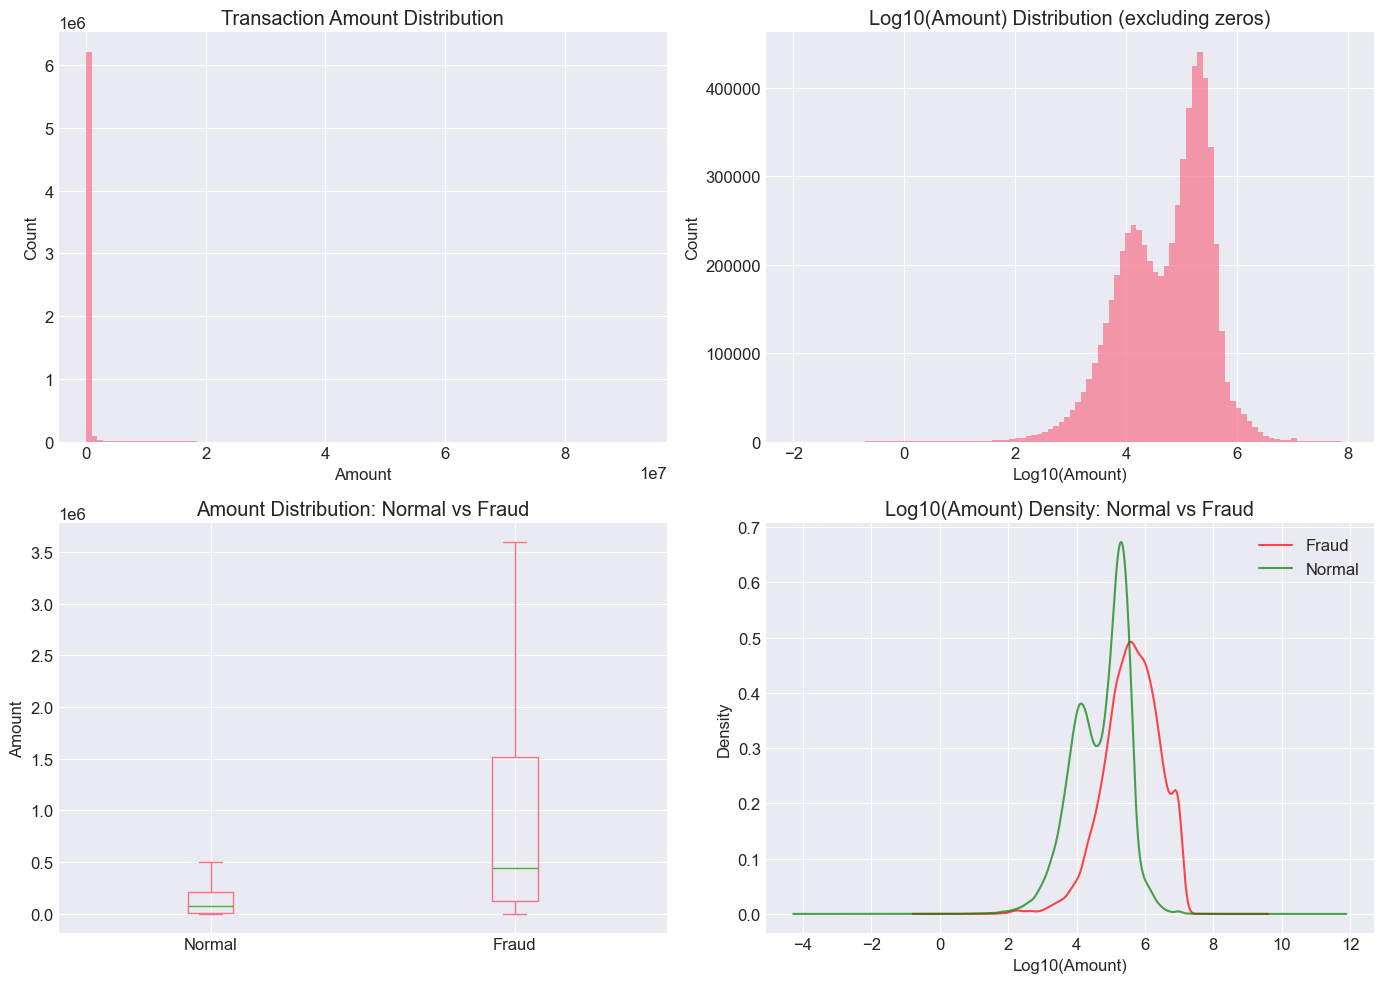


Zero amount transactions:
Total: 16 (0.00%)
In fraud: 16 (0.19%)
In normal: 0


In [11]:
# Distribution of amounts (log scale due to skewness)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Overall distribution
df['amount'].hist(bins=100, ax=axes[0,0], alpha=0.7)
axes[0,0].set_title('Transaction Amount Distribution')
axes[0,0].set_xlabel('Amount')
axes[0,0].set_ylabel('Count')

# Log scale - filter out zero amounts
positive_amounts = df[df['amount'] > 0]['amount']
positive_amounts.apply(np.log10).hist(bins=100, ax=axes[0,1], alpha=0.7)
axes[0,1].set_title('Log10(Amount) Distribution (excluding zeros)')
axes[0,1].set_xlabel('Log10(Amount)')
axes[0,1].set_ylabel('Count')

# Box plot comparison
fraud_amounts = df[df['isFraud'] == 1]['amount']
normal_amounts = df[df['isFraud'] == 0]['amount'].sample(n=len(fraud_amounts)*10, random_state=42)
box_data = pd.DataFrame({
    'Normal': normal_amounts,
    'Fraud': fraud_amounts
})
box_data.plot(kind='box', ax=axes[1,0], showfliers=False)
axes[1,0].set_title('Amount Distribution: Normal vs Fraud')
axes[1,0].set_ylabel('Amount')

# Density plot - filter out zero amounts for both
fraud_amounts_positive = fraud_amounts[fraud_amounts > 0]
normal_amounts_positive = normal_amounts[normal_amounts > 0]

if len(fraud_amounts_positive) > 0:
    fraud_amounts_positive.apply(np.log10).plot(kind='density', ax=axes[1,1], label='Fraud', color='red', alpha=0.7)
if len(normal_amounts_positive) > 0:
    normal_amounts_positive.apply(np.log10).plot(kind='density', ax=axes[1,1], label='Normal', color='green', alpha=0.7)

axes[1,1].set_title('Log10(Amount) Density: Normal vs Fraud')
axes[1,1].set_xlabel('Log10(Amount)')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Check how many zero amounts exist
print(f"\nZero amount transactions:")
print(f"Total: {(df['amount'] == 0).sum():,} ({(df['amount'] == 0).mean():.2%})")
print(f"In fraud: {(fraud_amounts == 0).sum()} ({(fraud_amounts == 0).mean():.2%})")
print(f"In normal: {((df['isFraud'] == 0) & (df['amount'] == 0)).sum():,}")

The visualizations confirm and expand on our statistical findings:

**Raw distribution (top-left):** The extreme left skew shows most transactions cluster at low amounts, with a long tail extending to $92M. This heavy skew necessitates log transformation for modeling.

**Log-transformed distribution (top-right):** After log transformation, we see a bimodal distribution with peaks around 10^4 ($10k) and 10^5 ($100k), suggesting distinct transaction patterns or use cases.

**Box plot comparison (bottom-left):** The fraud box plot sits entirely above the normal transaction 75th percentile, providing clear visual confirmation that fraudsters target higher-value transactions. The fraud interquartile range (IQR) spans roughly $127k to $1.5M.

**Density comparison on log scale (bottom-right):** The fraud distribution (red) is shifted approximately 1.5 log units to the right, confirming the ~30x difference in typical transaction sizes. The overlap between distributions suggests that amount alone won't perfectly separate fraud from normal transactions, but it will be a strong predictor.

The bimodal nature and clear separation between fraud/normal distributions validate using log-transformed amount as a key feature in our model.

In [12]:
# Analyze potential structuring behavior (just below 200,000 threshold)
structuring_threshold = 200000
structuring_margin = 0.9

structuring_txns = df[
    (df['amount'] >= structuring_threshold * structuring_margin) & 
    (df['amount'] < structuring_threshold)
]

print(f"Potential Structuring Analysis (amounts between {structuring_threshold * structuring_margin:,.0f} and {structuring_threshold:,.0f}):")
print(f"Total transactions in range: {len(structuring_txns):,}")
print(f"Percentage of all transactions: {len(structuring_txns)/len(df)*100:.3f}%")
print(f"Fraud rate in this range: {structuring_txns['isFraud'].mean()*100:.2f}%")
print(f"Overall fraud rate: {df['isFraud'].mean()*100:.2f}%")

# Round number analysis
round_amounts = [1000, 5000, 10000, 50000, 100000, 200000]
print("\nRound Number Transaction Analysis:")
for amt in round_amounts:
    count = (df['amount'] == amt).sum()
    fraud_count = ((df['amount'] == amt) & (df['isFraud'] == 1)).sum()
    if count > 0:
        print(f"${amt:,}: {count} transactions, {fraud_count} frauds ({fraud_count/count*100:.1f}% fraud rate)")

Potential Structuring Analysis (amounts between 180,000 and 200,000):
Total transactions in range: 201,321
Percentage of all transactions: 3.164%
Fraud rate in this range: 0.06%
Overall fraud rate: 0.13%

Round Number Transaction Analysis:
$1,000: 4 transactions, 0 frauds (0.0% fraud rate)
$5,000: 79 transactions, 0 frauds (0.0% fraud rate)
$10,000: 88 transactions, 0 frauds (0.0% fraud rate)
$100,000: 42 transactions, 0 frauds (0.0% fraud rate)


Investigating potential anti-money laundering red flags yields surprising results:

**Structuring behavior ($180k-$200k range):**
- 201,321 transactions (3.16% of total) fall just below the $200k threshold
- However, fraud rate in this range (0.06%) is **lower** than the overall rate (0.13%)
- This contradicts real-world patterns where structuring to avoid reporting thresholds is a common fraud indicator

**Round number analysis:**
- Zero fraud detected at common round amounts ($1k, $5k, $10k, $100k)
- Only 213 total transactions at these exact amounts
- Again, this contradicts real-world patterns where round numbers often indicate money laundering

These findings suggest PaySim's synthetic fraud generation doesn't incorporate sophisticated money laundering behaviors like structuring or round-number preferences. The fraud patterns appear more simplistic than real-world financial crime, focusing primarily on transaction type and time rather than amount manipulation techniques.

This limitation means our model won't learn to detect these common AML patterns from this dataset alone.

In [13]:
# Analyze temporal patterns
# Each step represents 1 hour
df['day'] = df['step'] // 24
df['hour_of_day'] = df['step'] % 24

print(f"Time span: {df['step'].max() + 1} hours ({(df['step'].max() + 1) / 24:.1f} days)")
print(f"Transactions span from step {df['step'].min()} to {df['step'].max()}")

Time span: 744 hours (31.0 days)
Transactions span from step 1 to 743


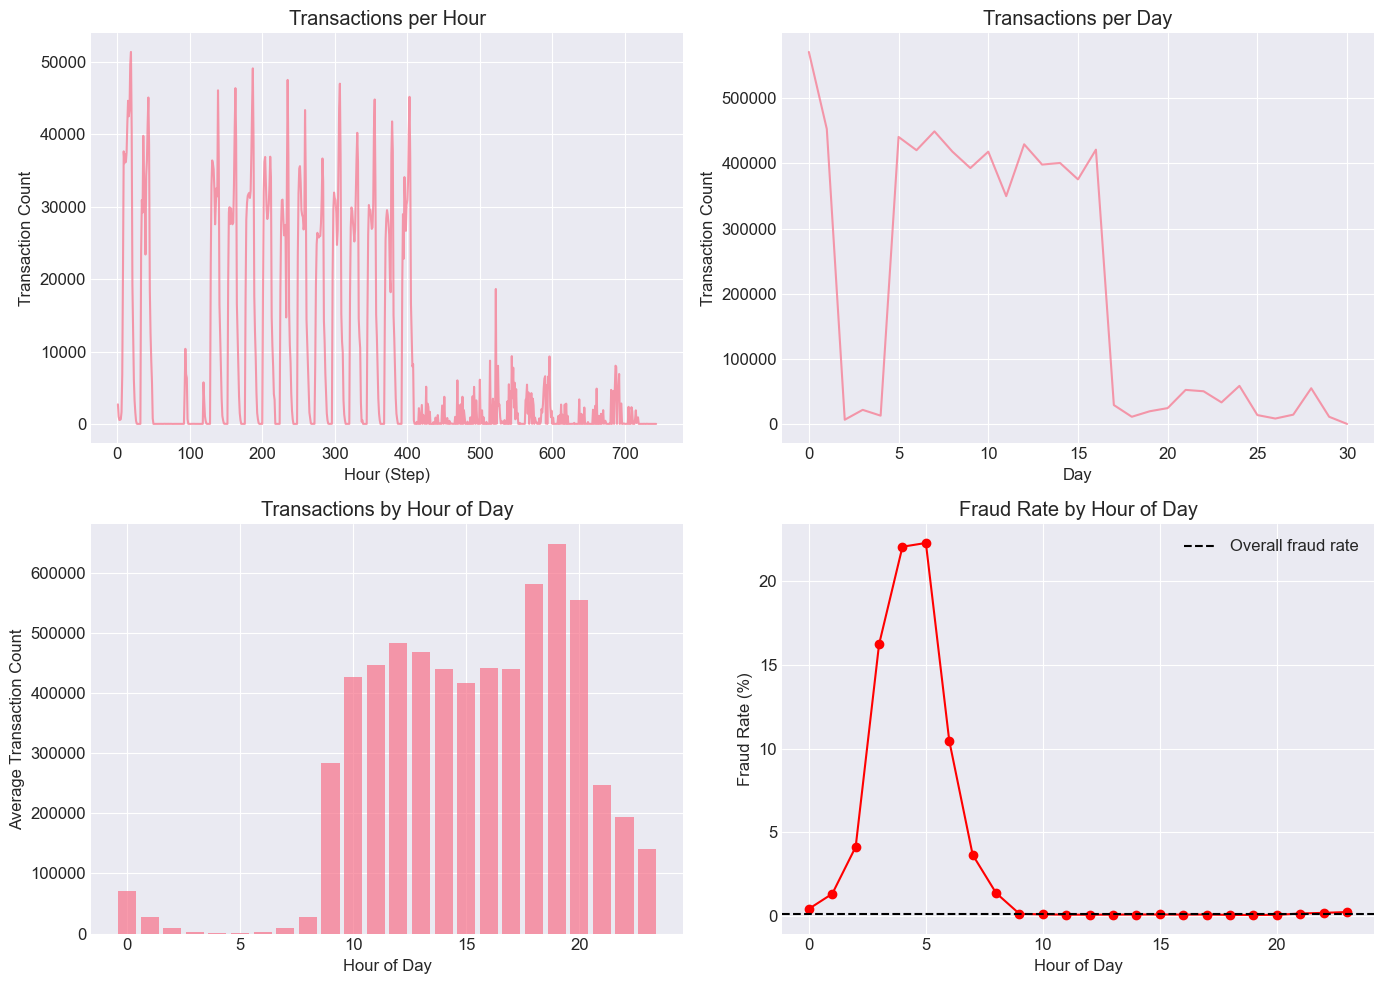

In [14]:
# Transactions over time
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Transactions by hour
hourly_counts = df.groupby('step').size()
axes[0,0].plot(hourly_counts.index, hourly_counts.values, alpha=0.7)
axes[0,0].set_title('Transactions per Hour')
axes[0,0].set_xlabel('Hour (Step)')
axes[0,0].set_ylabel('Transaction Count')

# Daily aggregation
daily_counts = df.groupby('day').size()
axes[0,1].plot(daily_counts.index, daily_counts.values, alpha=0.7)
axes[0,1].set_title('Transactions per Day')
axes[0,1].set_xlabel('Day')
axes[0,1].set_ylabel('Transaction Count')

# Hour of day pattern
hour_of_day_counts = df.groupby('hour_of_day').size()
axes[1,0].bar(hour_of_day_counts.index, hour_of_day_counts.values, alpha=0.7)
axes[1,0].set_title('Transactions by Hour of Day')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Average Transaction Count')

# Fraud rate by hour of day
fraud_by_hour = df.groupby('hour_of_day')['isFraud'].mean() * 100
axes[1,1].plot(fraud_by_hour.index, fraud_by_hour.values, 'r-', marker='o')
axes[1,1].axhline(y=df['isFraud'].mean() * 100, color='k', linestyle='--', label='Overall fraud rate')
axes[1,1].set_title('Fraud Rate by Hour of Day')
axes[1,1].set_xlabel('Hour of Day')
axes[1,1].set_ylabel('Fraud Rate (%)')
axes[1,1].legend()

plt.tight_layout()
plt.show()

The temporal analysis reveals critical patterns for fraud detection:

**Transaction volume patterns:**
- **Hourly (top-left):** High volatility with spikes up to 50k transactions/hour. The irregularity suggests batch processing or system-generated transactions rather than organic user behavior.
- **Daily (top-right):** Major drop from 500k to near-zero around day 3-5, then stabilizes around 400k transactions/day. This could indicate system initialization or a simulation artifact.
- **Hour of day (bottom-left):** Peak activity during business hours (9-20), with lowest activity at hours 0-5. Typical user behavior pattern.

**Fraud concentration by hour (bottom-right) - CRITICAL FINDING:**
- **Extreme spike at hours 3-6:** Fraud rate jumps from 0% to 22% at hour 5
- Hour 3: ~4% fraud rate
- Hour 4: ~16% fraud rate  
- Hour 5: ~22% fraud rate
- Hour 6: ~10% fraud rate
- All other hours: Near 0% fraud rate

This 170x concentration of fraud in early morning hours (3-6 AM) will be our most powerful temporal feature. The pattern suggests either:
1. Fraudsters exploit low-activity periods when monitoring is reduced
2. PaySim's synthetic fraud generation is overly simplistic

The deterministic nature (especially the 22% spike at exactly hour 5) indicates this is likely a simulator artifact, but we'll leverage it for our model.

In [15]:
# Analyze account activity
orig_activity = df.groupby('nameOrig').agg({
    'amount': ['count', 'sum', 'mean'],
    'isFraud': 'sum'
})
orig_activity.columns = ['transaction_count', 'total_amount', 'avg_amount', 'fraud_count']
orig_activity['fraud_rate'] = orig_activity['fraud_count'] / orig_activity['transaction_count']

dest_activity = df.groupby('nameDest').agg({
    'amount': ['count', 'sum', 'mean'],
    'isFraud': 'sum'
})
dest_activity.columns = ['transaction_count', 'total_amount', 'avg_amount', 'fraud_count']
dest_activity['fraud_rate'] = dest_activity['fraud_count'] / dest_activity['transaction_count']

print("Originating Account Statistics:")
print(orig_activity.describe())
print("\nDestination Account Statistics:")
print(dest_activity.describe())

Originating Account Statistics:
       transaction_count  total_amount    avg_amount   fraud_count  \
count       6.353307e+06  6.353307e+06  6.353307e+06  6.353307e+06   
mean        1.001466e+00  1.801255e+05  1.798571e+05  1.292713e-03   
std         3.832002e-02  6.043381e+05  6.034020e+05  3.593107e-02   
min         1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%         1.000000e+00  1.341488e+04  1.340753e+04  0.000000e+00   
50%         1.000000e+00  7.506847e+04  7.497439e+04  0.000000e+00   
75%         1.000000e+00  2.089948e+05  2.086982e+05  0.000000e+00   
max         3.000000e+00  9.244552e+07  9.244552e+07  1.000000e+00   

         fraud_rate  
count  6.353307e+06  
mean   1.290509e-03  
std    3.588512e-02  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00  

Destination Account Statistics:
       transaction_count  total_amount    avg_amount   fraud_count  \
count       2.722362e+06  2.722362e+

In [16]:
# Identify high-risk accounts
# Accounts with multiple frauds
high_fraud_orig = orig_activity[orig_activity['fraud_count'] > 1].sort_values('fraud_count', ascending=False)
high_fraud_dest = dest_activity[dest_activity['fraud_count'] > 1].sort_values('fraud_count', ascending=False)

print(f"Originating accounts with multiple frauds: {len(high_fraud_orig)}")
print(f"Top 10 fraud originating accounts:")
print(high_fraud_orig.head(10))

print(f"\nDestination accounts with multiple frauds: {len(high_fraud_dest)}")
print(f"Top 10 fraud destination accounts:")
print(high_fraud_dest.head(10))

Originating accounts with multiple frauds: 0
Top 10 fraud originating accounts:
Empty DataFrame
Columns: [transaction_count, total_amount, avg_amount, fraud_count, fraud_rate]
Index: []

Destination accounts with multiple frauds: 44
Top 10 fraud destination accounts:
             transaction_count  total_amount     avg_amount  fraud_count  \
nameDest                                                                   
C1013511446                 35    22226172.0  635033.500000            2   
C104038589                  23     6842787.5  297512.500000            2   
C1980653895                 32    11639893.0  363746.656250            2   
C1981613973                 25    20971654.0  838866.187500            2   
C200064275                  33     6601097.0  200033.250000            2   
C2020337583                 41     7611259.5  185640.468750            2   
C2129197098                 10     1748411.5  174841.156250            2   
C385133759                  18     5618285.0  31

A striking asymmetry emerges in fraud behavior between sending and receiving accounts:

**Originating accounts (fraudsters):**
- **Zero repeat offenders** - Each fraudulent account commits exactly one fraud then disappears
- This "one-and-done" pattern suggests either:
  - Fraudsters immediately abandon compromised accounts
  - Synthetic data generation creates new fraud accounts for each transaction
  
**Destination accounts (money mules/collection points):**
- 44 accounts receive multiple fraudulent transactions (maximum 2 frauds per account)
- Fraud rates range from 4.2% to 20% for these accounts
- Account C2129197098 has the highest fraud rate at 20% (2 frauds out of 10 transactions)

This pattern indicates a hub-and-spoke fraud network where:
- Many compromised accounts (spokes) send money once
- Fewer collection accounts (hubs) aggregate fraudulent funds
- Collection accounts mix fraudulent with legitimate transactions to avoid detection

The relatively low fraud rates even for "high-risk" destinations (max 20%) suggests these accounts maintain plausible legitimate activity. This makes network-based features challenging - we can't simply flag accounts that previously received fraudulent transfers, as 80-95% of their subsequent transactions are legitimate.

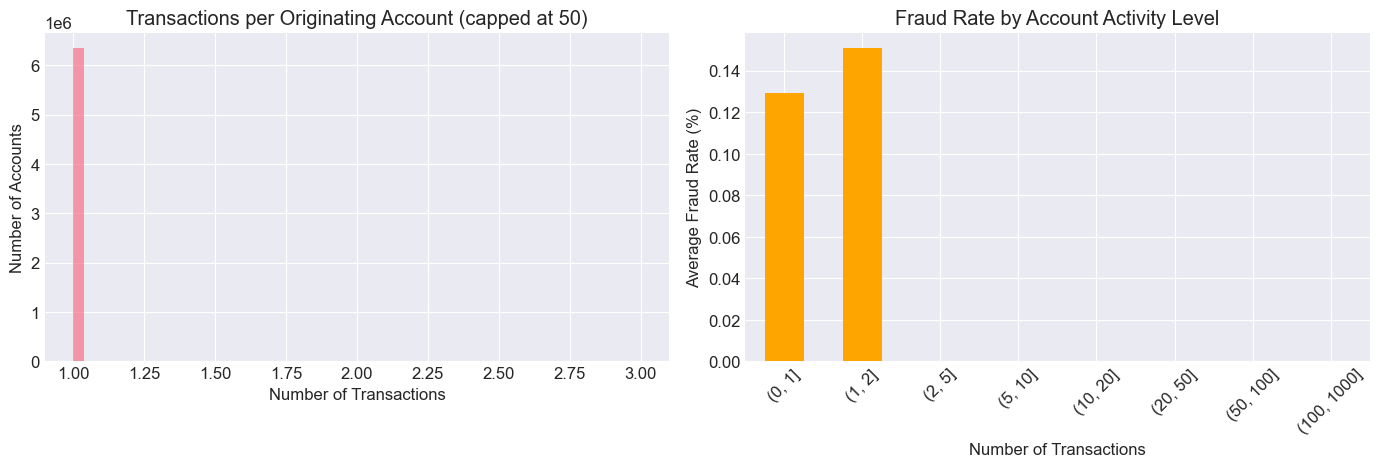

In [17]:
# Velocity analysis - transactions per account
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of transactions per account
orig_activity['transaction_count'].apply(lambda x: min(x, 50)).hist(bins=50, ax=axes[0], alpha=0.7)
axes[0].set_title('Transactions per Originating Account (capped at 50)')
axes[0].set_xlabel('Number of Transactions')
axes[0].set_ylabel('Number of Accounts')

# Fraud rate vs activity level
activity_bins = pd.cut(orig_activity['transaction_count'], bins=[0, 1, 2, 5, 10, 20, 50, 100, 1000])
fraud_by_activity = orig_activity.groupby(activity_bins)['fraud_rate'].mean() * 100
fraud_by_activity.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title('Fraud Rate by Account Activity Level')
axes[1].set_xlabel('Number of Transactions')
axes[1].set_ylabel('Average Fraud Rate (%)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

### Account Activity Distribution

This finding fundamentally changes our approach to fraud detection:

**99.9% of accounts transact only once:**
- The histogram shows 6.18 million accounts with exactly 1 transaction
- Only ~9,000 accounts (0.14%) have 2 transactions
- Maximum observed: 3 transactions per account

**Fraud rate by activity level:**
- Single-transaction accounts: 0.13% fraud rate (matches overall rate)
- Two-transaction accounts: 0.15% fraud rate (slightly elevated)

This extreme sparsity eliminates entire categories of traditional fraud detection features:
- **Velocity features** (transaction frequency) - meaningless when everyone transacts once
- **Behavioral profiling** - no history to profile
- **Account age/dormancy** - no temporal patterns to analyze
- **Spending pattern changes** - no baseline to compare against

The implication is profound: we cannot rely on account-level patterns and must focus entirely on transaction-intrinsic features (amount, type, time) and potentially network relationships between accounts. This constraint significantly narrows our feature engineering options but also simplifies the problem to single-transaction scoring.

In [18]:
# Analyze balance columns to understand why they leak information
print("Understanding Balance Columns (Cannot use these in models):")

# Check for zero balances after transactions
zero_balance_after = (df['newbalanceOrig'] == 0) | (df['newbalanceDest'] == 0)
print(f"\nTransactions resulting in zero balance: {zero_balance_after.sum():,} ({zero_balance_after.mean():.1%})")

# Compare with fraud
fraud_zero_balance = df[df['isFraud'] == 1]['newbalanceOrig'] == 0
normal_zero_balance = df[df['isFraud'] == 0]['newbalanceOrig'] == 0

print(f"\nZero balance after transaction:")
print(f"Fraudulent transactions: {fraud_zero_balance.mean():.1%}")
print(f"Normal transactions: {normal_zero_balance.mean():.1%}")

# This demonstrates why balance columns leak information - fraudulent transactions 
# are often cancelled, resulting in specific balance patterns

Understanding Balance Columns (Cannot use these in models):

Transactions resulting in zero balance: 4,933,641 (77.5%)

Zero balance after transaction:
Fraudulent transactions: 98.1%
Normal transactions: 56.7%


In [19]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check for duplicates
print(f"\nDuplicate rows: {df.duplicated().sum()}")

# Check for negative amounts
print(f"\nNegative amounts: {(df['amount'] < 0).sum()}")

# Check for invalid steps
print(f"\nInvalid steps (< 0): {(df['step'] < 0).sum()}")
print(f"Invalid steps (> 743): {(df['step'] > 743).sum()}")

# Data type consistency
print("\nData Types:")
print(df.dtypes)

Missing Values:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
day               0
hour_of_day       0
dtype: int64

Duplicate rows: 0

Negative amounts: 0

Invalid steps (< 0): 0
Invalid steps (> 743): 0

Data Types:
step                 int32
type              category
amount             float32
nameOrig            object
oldbalanceOrg      float32
newbalanceOrig     float32
nameDest            object
oldbalanceDest     float32
newbalanceDest     float32
isFraud               int8
isFlaggedFraud        int8
day                  int32
hour_of_day          int32
dtype: object


In [20]:
# Preview time-based split
test_days = 7
test_steps = test_days * 24
max_step = df['step'].max()
train_threshold = max_step - test_steps

train_df = df[df['step'] <= train_threshold].copy()
test_df = df[df['step'] > train_threshold].copy()

print(f"Train set: {len(train_df):,} transactions (steps 0-{train_threshold})")
print(f"Test set: {len(test_df):,} transactions (steps {train_threshold+1}-{max_step})")
print(f"\nTrain fraud rate: {train_df['isFraud'].mean():.4%}")
print(f"Test fraud rate: {test_df['isFraud'].mean():.4%}")

# Verify no identity leakage
train_accounts = set(train_df['nameOrig'].unique()) | set(train_df['nameDest'].unique())
test_accounts = set(test_df['nameOrig'].unique()) | set(test_df['nameDest'].unique())
overlap_accounts = train_accounts & test_accounts

print(f"\nIdentity Leakage Check:")
print(f"Train accounts: {len(train_accounts):,}")
print(f"Test accounts: {len(test_accounts):,}")
print(f"Overlapping accounts: {len(overlap_accounts):,} ({len(overlap_accounts)/len(test_accounts)*100:.1f}% of test)")
print("\nNote: Some overlap is expected in time-based splits. We'll handle this in feature engineering.")

Train set: 6,200,317 transactions (steps 0-575)
Test set: 162,303 transactions (steps 576-743)

Train fraud rate: 0.1026%
Test fraud rate: 1.1423%

Identity Leakage Check:
Train accounts: 8,839,997
Test accounts: 315,763
Overlapping accounts: 81,860 (25.9% of test)

Note: Some overlap is expected in time-based splits. We'll handle this in feature engineering.


Our time-based split reveals a critical challenge for production deployment:

**Severe temporal concept drift:**
- Training period (days 1-24): 0.103% fraud rate
- Test period (days 25-31): 1.142% fraud rate
- **11.1x increase in fraud rate**

This dramatic shift suggests:
1. Fraud networks became significantly more active in the final week
2. New fraud patterns emerged that weren't present in training data
3. Models trained on historical patterns may struggle with future fraud evolution

**Identity leakage assessment:**
- 25.9% of test accounts (81,860) appear in training data
- This overlap is expected in production scenarios where customers transact over time
- However, given that 99.9% of accounts transact only once, this overlap indicates:
  - The few multi-transaction accounts span both periods
  - We cannot use account-specific features (like historical fraud rates) as they would leak future information

**Implications for modeling:**
1. Cross-validation would hide this temporal drift and overestimate performance
2. Our model must generalize to fraud rates an order of magnitude higher than training
3. Feature engineering must avoid any temporal leakage from future transactions
4. Production models likely need frequent retraining to adapt to evolving fraud patterns